In [4]:
import numpy as np
import matplotlib.pyplot as plt
import math
import copy

# %matplotlib notebook
%matplotlib inline

In [2]:
class Data:
    def __init__(self, params):
        self.a = params['a']
        self.b = params['b']
        self.c = params['c']
        self.d = params['d']
        self.lx = params['lx']
        self.ly = params['ly']
        self.w = params['w']
        self.f = params['f']
        self.alpha1 = params['alpha1']
        self.alpha2 = params['alpha2']
        self.beta1 = params['beta1']
        self.beta2 = params['beta2']
        self.gamma1 = params['gamma1']
        self.gamma2 = params['gamma2']
        self.delta1 = params['delta1']
        self.delta2 = params['delta2']
        self.phi1 = params['phi1']
        self.phi2 = params['phi2']
        self.phi3 = params['phi3']
        self.phi4 = params['phi4']
        self.solution = params['solution']

In [6]:
def diff(L, u, nx, ny):
    mx = 0
    for i in range(nx):
        for j in range(ny):
            mx = max(mx, abs(u[i][j] - L[i][j]))
    return mx

def compareError(a, b):
    err = 0
    lst = [abs(i - j) for i, j in zip(a, b)]
    for each in lst:
        err = max(err, each)
    return err


In [31]:
class ElepticalSolver:
    def __init__(self, params, nx, ny):
        self.data = Data(params)
        iteration = 0
        self.eps = 1e-6

        self.nx = nx
        self.ny = ny
        self.hx = self.data.lx / nx
        self.hy = self.data.ly / ny
        x = np.arange(0, self.data.lx + self.hx, self.hx)
        y = np.arange(0, self.data.ly + self.hy, self.hy)

        self.x = x
        self.y = y

        u = self.initalizeU(x, y)
        for i in range(1, nx):
            for j in range(1, ny):
                u[i][j] = u[0][j] + (x[i] - x[0]) * (u[-1][j] - u[0][j]) / (x[-1] - x[0])

        self.u = u

    def initalizeU(self, x, y):
        u = np.zeros((len(x), len(y)))
        for i in range(len(x)):
            u[i][0] = self.data.phi3(x[i]) / self.data.gamma1
            u[i][-1] = self.data.phi4(x[i]) / self.data.delta1
        for j in range(len(y)):
            u[0][j] = self.data.phi1(y[j]) / self.data.alpha2
            u[-1][j] = self.data.phi2(y[j]) / self.data.beta2

        return u


    def analyticSolve(self):
        nx, ny = self.nx, self.ny
        self.hx = self.data.lx / nx
        self.hy = self.data.ly / ny
        x = np.arange(0, self.data.lx + self.hx, self.hx)
        y = np.arange(0, self.data.ly + self.hy, self.hy)

        u = []
        for yi in y:
            u.append([self.data.solution(xi, yi) for xi in x])
        # for xi, yi in zip(x, y):
        #     u.append(self.data.solution(xi, yi))
        return u

    # метод простых итераций (метод Либмана)
    def simpleIterationMethod_solver(self):
        nx, ny = self.nx, self.ny
        x, y, u = self.x, self.y, self.u
        iteration = 0

        cur_eps = 1e9
        while iteration < 10000:
            L = copy.deepcopy(u)
            u = self.initalizeU(x, y)
            for j in range(1, len(y) - 1):
                for i in range(1, len(x) - 1):
                    u[i][j] = (self.hx * self.hx * self.data.f(x[i], y[j]) -
                               (L[i + 1][j] + L[i - 1][j]) - self.data.d * self.hx * self.hx *
                               (L[i][j + 1] + L[i][j - 1]) /
                               (self.hy * self.hy) - self.data.a * self.hx * 0.5 *
                               (L[i + 1][j] - L[i - 1][j]) - self.data.b * self.hx * self.hx *
                               (L[i][j + 1] - L[i][j - 1]) /
                               (2 * self.hy)) / (self.data.c * self.hx * self.hx - 2 *
                                                 (self.hy * self.hy + self.data.d * self.hx * self.hx) /
                                                 (self.hy * self.hy))
            last_eps = cur_eps
            cur_eps = diff(L, u, nx, ny)
            if diff(L, u, nx, ny) <= self.eps or last_eps < cur_eps:
                break
            iteration += 1
        return u, iteration

    # метод Зейделя
    def seidelMethod_solver(self):
        nx, ny = self.nx, self.ny
        x, y, u = self.x, self.y, self.u
        iteration = 0

        cur_eps = 1e9
        while iteration < 10000:
            L = copy.deepcopy(u)
            u = self.initalizeU(x, y)
            for j in range(1, len(y) - 1):
                for i in range(1, len(x) - 1):
                    u[i][j] = ((self.hx ** 2) * self.data.f(x[i], y[j]) -
                               (L[i + 1][j] + u[i - 1][j]) - self.data.d * (self.hx ** 2) *
                               (L[i][j + 1] + u[i][j - 1]) / (self.hy ** 2) - self.data.a * self.hx * 0.5 *
                               (L[i + 1][j] - u[i - 1][j]) - self.data.b * (self.hx ** 2) *
                               (L[i][j + 1] - u[i][j - 1]) /
                               (2 * self.hy)) / \
                              (self.data.c * (self.hx ** 2) - 2 * (self.hy ** 2 + self.data.d * (self.hx ** 2)) /
                               (self.hy ** 2))
            last_eps = cur_eps
            cur_eps = diff(L, u, nx, ny)
            if cur_eps <= self.eps or last_eps < cur_eps:
                break
            iteration += 1
        return u, iteration

    # метод простых итераций с верхней релаксацией
    def simpleIterationMethodRelaxed_solver(self):
        nx, ny = self.nx, self.ny
        x, y, u = self.x, self.y, self.u
        iteration = 0

        cur_eps = 1e9
        while iteration < 10000:
            L = copy.deepcopy(u)
            u = self.initalizeU(x, y)
            for j in range(1, len(y) - 1):
                for i in range(1, len(x) - 1):
                    u[i][j] = (((self.hx ** 2) * self.data.f(x[i], y[j]) -
                                (L[i + 1][j] + u[i - 1][j]) - self.data.d * (self.hx ** 2) *
                                (L[i][j + 1] + u[i][j - 1]) / (self.hy ** 2) - self.data.a * self.hx * 0.5 *
                                (L[i + 1][j] - u[i - 1][j]) - self.data.b * (self.hx ** 2) *
                                (L[i][j + 1] - u[i][j - 1]) /
                                (2 * self.hy)) / (self.data.c * (self.hx ** 2) - 2 *
                                                  (self.hy ** 2 + self.data.d * (self.hx ** 2)) /
                                                  (self.hy ** 2))) * self.data.w + (1 - self.data.w) * L[i][j]
            last_eps = cur_eps
            cur_eps = diff(L, u, nx, ny)
            if diff(L, u, nx, ny) <= self.eps or last_eps < cur_eps:
                break
            iteration += 1
        return u, iteration

In [32]:
nx = 40
ny = 40

In [45]:
params = {
    'a': 0,
    'b': 0,
    'c': 0,
    'd': 1,
    'lx': 1,
    'ly': np.pi / 2,
    'w': 1.5,
    'f': lambda x, y: 0,
    'alpha1': 0,
    'alpha2': 1,
    'beta1': 0,
    'beta2': 1,
    'gamma1': 1,
    'gamma2': 0,
    'delta1': 1,
    'delta2': 0,
    'phi1': lambda y: np.cos(y),
    'phi2': lambda y: np.exp(1) * np.cos(y),
    'phi3': lambda x: 0,
    'phi4': lambda x: -np.exp(x),
    'solution': lambda x, y: np.exp(x) * np.cos(y),
}

In [46]:
solver = ElepticalSolver(params, nx, ny)
X = np.arange(0, np.pi / 2 + np.pi / 2 / nx, np.pi / 2 / nx)
Y = np.arange(0, np.pi / 2 + np.pi / 2 / ny, np.pi / 2 / ny)

Количество итераций:
Метод простых итераций 2593
Метод Зейделя 1410
Метод простых итераций с верхней релаксацией 526


Text(0.5, 0, 'u Label')

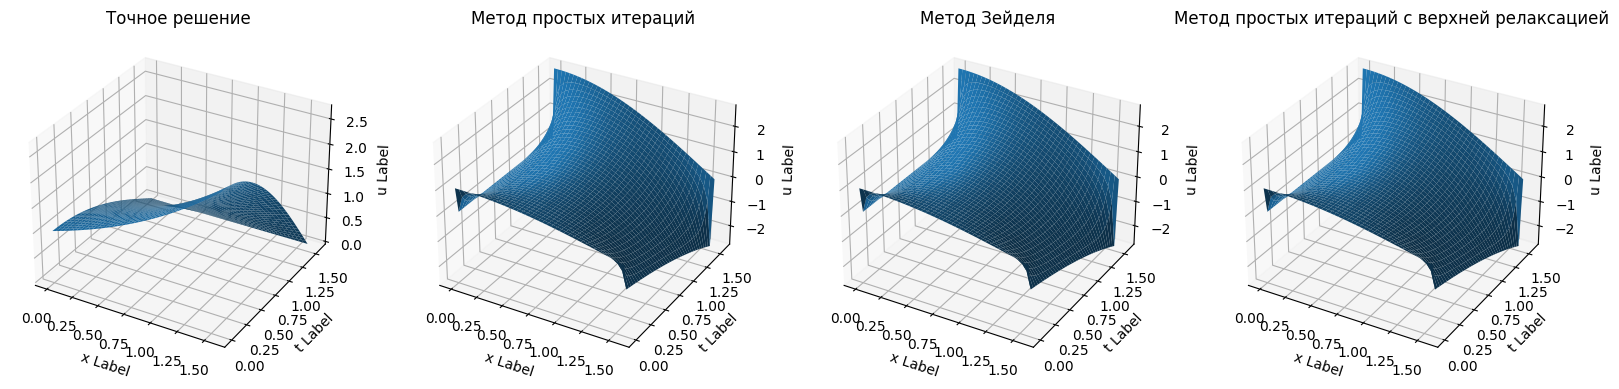

In [47]:
fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(1, 4, 1, projection='3d')
ax.set_title('Точное решение')

U = solver.analyticSolve()

W, Q = np.meshgrid(X, Y)
ax.plot_surface(W, Q, np.array(U))

ax.set_xlabel('x Label')
ax.set_ylabel('t Label')
ax.set_zlabel('u Label')

print('Количество итераций:')

# ________________________________________________________________________


ax = fig.add_subplot(1, 4, 2, projection='3d')
ax.set_title('Метод простых итераций')


u, iteration= solver.simpleIterationMethod_solver()
print('Метод простых итераций', iteration)

W, Q = np.meshgrid(X, Y)

ax.plot_surface(W, Q, np.array(u))

ax.set_xlabel('x Label')
ax.set_ylabel('t Label')
ax.set_zlabel('u Label')

# ________________________________________________________________________

ax = fig.add_subplot(1, 4, 3, projection='3d')
ax.set_title('Метод Зейделя')

u, iteration = solver.seidelMethod_solver()
print('Метод Зейделя', iteration)

W, Q = np.meshgrid(X, Y)
ax.plot_surface(W, Q, np.array(u))

ax.set_xlabel('x Label')
ax.set_ylabel('t Label')
ax.set_zlabel('u Label')

# ________________________________________________________________________

ax = fig.add_subplot(1, 4, 4, projection='3d')
ax.set_title('Метод простых итераций с верхней релаксацией')

u, iteration = solver.simpleIterationMethodRelaxed_solver()
print('Метод простых итераций с верхней релаксацией', iteration)

W, Q = np.meshgrid(X, Y)
ax.plot_surface(W, Q, np.array(u))

ax.set_xlabel('x Label')
ax.set_ylabel('t Label')
ax.set_zlabel('u Label')
